## 0. 모델 고정해서 사용하기

In [19]:
!pip install keras-tuner

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [21]:
# 모델 생성
model = Sequential([
    # 첫 번째 컨볼루션 블록
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    AveragePooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # 두 번째 컨볼루션 블록
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # 플래튼 레이어
    Flatten(),

    # 완전 연결 레이어
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax') # 출력 클래스가 10개인 경우
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 15, 15, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 15, 15, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 6, 6, 64)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 612,426 (2.34 MB)

 Trainable params: 612,234 (2.34 MB)

 Non-trainable params: 192 (768.00 B)

## 1. Data Centric AI 맛보기

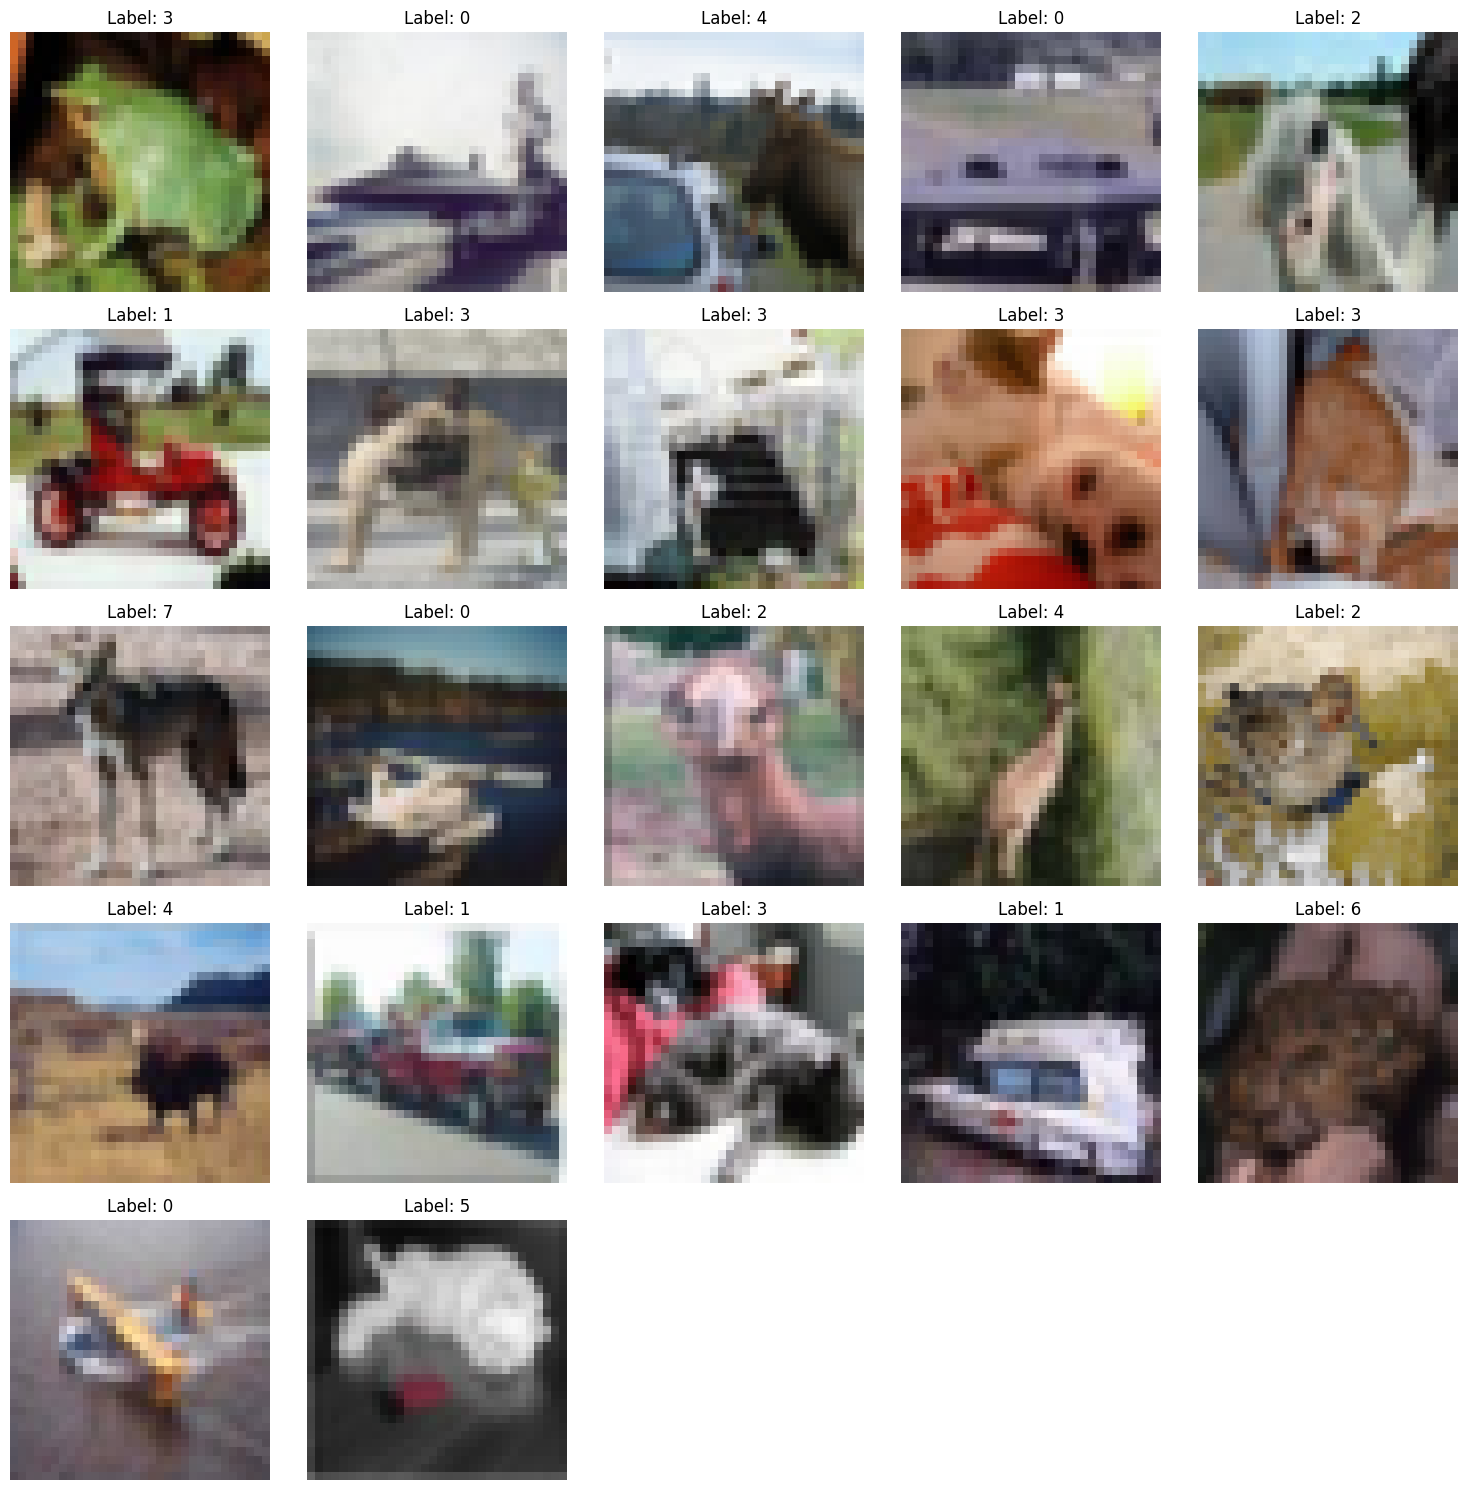

In [22]:
# CIFAR-10 데이터 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# ID 기반 시각화
def visualize_data(ids, images, labels):
    # 행과 열 계산
    total_images = len(ids)
    rows, cols = 5, 5  # 기본 그리드 크기
    max_plots = rows * cols

    # 서브플롯 생성
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    # 이미지 추가
    for ax, idx in zip(axes.ravel(), ids):
        ax.imshow(images[idx])
        ax.set_title(f"Label: {labels[idx][0]}")
        ax.axis('off')  # 축 제거

    # 빈 서브플롯 제거
    if total_images < max_plots:
        for ax in axes.ravel()[total_images:]:
            fig.delaxes(ax)  # 빈 subplot 제거

    # 레이아웃 정리
    plt.tight_layout()
    plt.show()

# 잘못된 라벨 ID
error_ids = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]  # labelerrors.com에서 확인한 ID
visualize_data(error_ids, x_test, y_test)

# 라벨 수정
correct_labels = [6, 8, 7, 1, 7, 9, 5, 9, 5, 5, 4, 8, 4, 2, 3, 2, 9, 5, 9, 3, 8, 3]  # 수정할 라벨 값
for i, idx in enumerate(error_ids):
    y_test[idx] = correct_labels[i]

## 2. 하이퍼파라미터 튜닝

In [23]:
# 모델 정의 함수
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu', input_shape=(32, 32, 3)),
        AveragePooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(hp.Int('conv2_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        AveragePooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'),
        Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.5])),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # 시도할 모델의 개수
    executions_per_trial=2,  # 각 하이퍼파라미터 조합별 반복 횟수
    directory='cifar10_tuning',
    project_name='cifar10_project'
)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# 최적의 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"최적 필터 크기 1: {best_hps.get('conv1_filters')}")
print(f"최적 필터 크기 2: {best_hps.get('conv2_filters')}")
print(f"최적 드롭아웃 비율: {best_hps.get('dropout_rate')}")

Trial 10 Complete [00h 02m 47s]
val_accuracy: 0.722900003194809

Best val_accuracy So Far: 0.7407999932765961
Total elapsed time: 00h 33m 17s
최적 필터 크기 1: 32
최적 필터 크기 2: 64
최적 드롭아웃 비율: 0.5


In [25]:
# 최적 하이퍼파라미터로 모델 생성 및 학습
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# 모델 저장
model.save('cifar10_saved_model.h5')

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4086 - loss: 1.9451 - val_accuracy: 0.5232 - val_loss: 1.3337
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6010 - loss: 1.1402 - val_accuracy: 0.5826 - val_loss: 1.2406
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6603 - loss: 0.9628 - val_accuracy: 0.6218 - val_loss: 1.1204
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7012 - loss: 0.8499 - val_accuracy: 0.7119 - val_loss: 0.8307
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7322 - loss: 0.7547 - val_accuracy: 0.6967 - val_loss: 0.8907
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7609 - loss: 0.6813 - val_accuracy: 0.7318 - val_loss: 0.7998
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7831 - loss: 0.6208 - val_accuracy: 0.6346 - val_loss: 1.0762
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7998 - loss: 0.5654 

## 3. 모델 배포하기 (옵션)

## 4. TFLite 모델 만들기 (옵션)

In [26]:
import tensorflow as tf

# HDF5 파일로 저장된 모델 로드
model = tf.keras.models.load_model('cifar10_saved_model.h5')

# TFLite 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# TFLite 파일 저장
with open('cifar10_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite 모델이 성공적으로 저장되었습니다!")

Saved artifact at '/tmp/tmpu3e2dlbn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139761627406656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139761627411584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139761627474656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139761627476416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139761627473952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139761627475184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139761627479232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139761627549008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139761627555520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139761627557280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13976162755305

In [27]:
# TFLite 모델 서명 확인
interpreter = tf.lite.Interpreter(model_path='cifar10_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("입력 텐서 정보:", input_details)
print("출력 텐서 정보:", output_details)

입력 텐서 정보: [{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
출력 텐서 정보: [{'name': 'StatefulPartitionedCall_1:0', 'index': 25, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
